In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
os.environ['TORCH_HOME'] = "/media/hdd/Datasets/"
import sys
sys.path.append("../")

In [2]:
from sprintdl.main import *
import sprintdl

In [3]:
device = torch.device('cuda',0)
from torch.nn import init
import torch
import math

# Define required

In [4]:
fpath = Path("/media/hdd/Datasets/ArtClass/")

tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
bs = 256

# Actual process

In [5]:
il = ImageList.from_files(fpath, tfms=tfms)

In [6]:
il

ImageList (36702 items)
[PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/69030963_140928767119437_3621699865915593113_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/72464485_484151519164558_7996390942427275987_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/67061598_659075951237852_8193482831220395614_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/52369429_387255328723206_9033916457772710578_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/67249582_2358754971005882_1419227919627445111_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/53117277_787218161655836_7400982805295717482_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/66306740_2081645612139014_2862011611265245646_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/51053509_419271458822091_6368645951995838212_n.jpg'), PosixPath('/media/hdd/Datasets/ArtClass/Unpopular/mim

In [7]:
tm= Path("/media/hdd/Datasets/ArtClass/Unpopular/mimang.art/69030963_140928767119437_3621699865915593113_n.jpg")

In [8]:
sd = SplitData.split_by_func(il, partial(random_splitter, p_valid = .2))
ll = label_by_func(sd, lambda x: str(x).split("/")[-3], proc_y=CategoryProcessor())

In [9]:
n_classes = len(set(ll.train.y.items))

In [12]:
data = ll.to_databunch(bs, c_in=3, c_out=2)

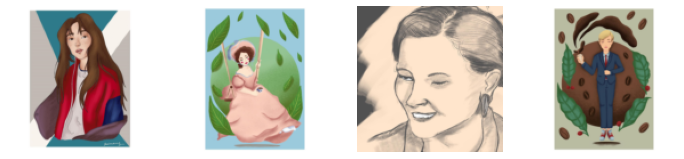

In [13]:
show_batch(data, 4)

# Darknet

In [15]:
dark = sprintdl.models.darknet.Darknet([1, 2, 4, 6, 3], num_classes=n_classes, nf=32)

# Training

In [16]:
lr = .001
pct_start = 0.5
phases = create_phases(pct_start)
sched_lr  = combine_scheds(phases, cos_1cycle_anneal(lr/10., lr, lr/1e5))
sched_mom = combine_scheds(phases, cos_1cycle_anneal(0.95, 0.85, 0.95))

cbfs = [
    partial(AvgStatsCallback,accuracy),
    partial(ParamScheduler, 'lr', sched_lr),
    partial(ParamScheduler, 'mom', sched_mom),
        partial(BatchTransformXCallback, norm_imagenette),
    ProgressCallback,
    Recorder,
#     MixUp,
       partial(CudaCallback, device)]

loss_func=LabelSmoothingCrossEntropy()
opt_func = adam_opt(mom=0.9, mom_sqr=0.99, eps=1e-6, wd=1e-2)

In [17]:
clear_memory()

In [18]:
learn = Learner(dark,  data, loss_func, lr=lr, cb_funcs=cbfs, opt_func=opt_func)

In [19]:
# model_summary(learn, data)

In [20]:
learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.681592,0.625116,0.609395,0.693981,01:58


In [21]:
save_model(learn, "m1", fpath)

Saved at /media/hdd/Datasets/ArtClass/models/m1


PosixPath('/media/hdd/Datasets/ArtClass/models/m1')

In [25]:
temp = Path('/home/eragon/Downloads/Telegram Desktop/IMG_20210106_180731.jpg')

In [28]:
get_class_pred(temp, learn ,ll,128)

'Popular'

# Digging in

In [29]:
classification_report(learn, n_classes, device)

tensor([0.2377, 0.9133])
tensor([[ 868., 2783.],
        [ 333., 3509.]])


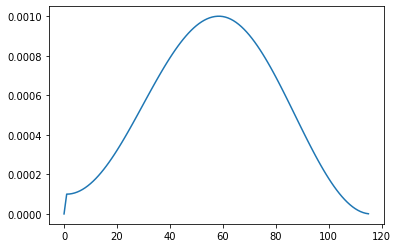

In [30]:
learn.recorder.plot_lr()

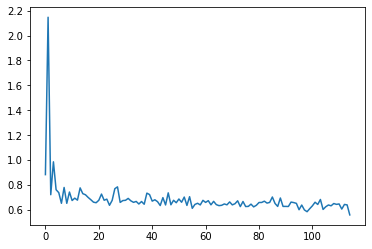

In [31]:
learn.recorder.plot_loss()

# Model vis

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,0.615970,0.681023,0.592461,0.716669,02:05


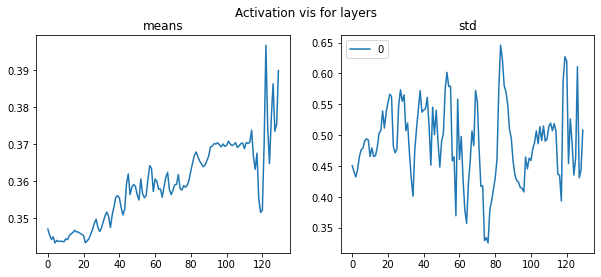

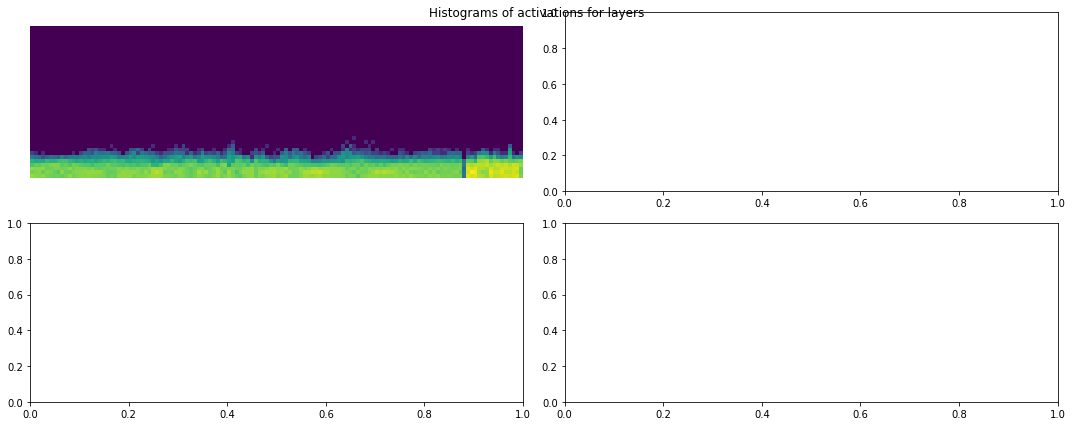

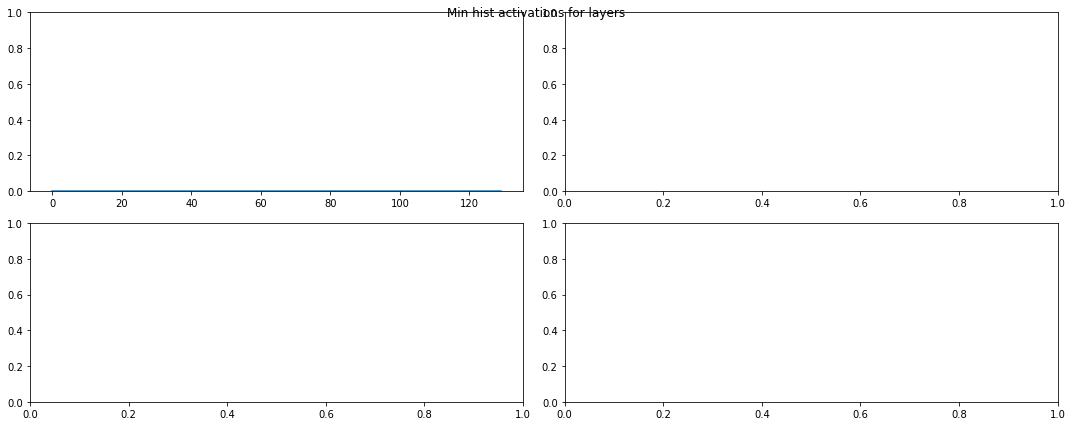

In [32]:
run_with_act_vis(1, learn)